# Import Modules

In [2]:
import numpy as np
import time
import datetime
import scipy
from scipy import spatial
from scipy import stats
import matplotlib.pylab as plt
import subprocess
import os
import re
import skipthoughts
import spacy
from spacy import displacy
from depkernel import TreeKernel

# Load and preprocess texts

In [12]:
path = "XXX" ## set path to where the text files are
data_file = open("thesis_txts/amr-bank-struct-v1.6-training.txt", "r", encoding="utf-8")
data = data_file.readlines()
new = []
snts = []
ch = -10

## Iterate over the data, which also containts some other meta data
## Save the English sentences in snts, and the sentences and AMRs in new
for i, line in enumerate(data):
    if i > 1:
        if i == ch+3:
            continue
        elif i == ch+4:
            continue
        elif i == ch+5:
            continue
        else:
            if line[:7] == "# ::snt":
                if line[:15] != "# ::snt Chapter":
                    new.append(line)
                    snts.append(line[7:].strip())
                else:
                    ch = i
            elif line[:6] == "# ::id":
                new.append(line)
            elif line[0] == "#":
                continue
            else:
                new.append(line)
                
# See how much we've reduced
# print(len(data))
# print(len(new))

## Write only the selected info in a new file
new_file = open("dev.txt","w+")
for line in new:
    new_file.write(line)
data_file.close()
new_file.close()
print("Done")

15690
13056
Done


In [13]:
## For the AMRs, every sentence/AMR has to be in its own file
## Split the text file and write every sentence in a new file
n = 0
small1 = []
small2 = []
now = []
for line in new:
    if line == "\n":
        current = open("txt_{}.txt".format(n), "w+")
        for line in now:
            current.write(line)
        current.close()
        n += 1
        now = []
    else:
        now.append(line)
## Don't forget the last one
current = open("txt_{}.txt".format(n), "w+")
for line in now:
    current.write(line)
current.close()
print(n)

1252



In [54]:
print(now)

['# ::id lpp_1943.1562 ::annotator ISI-AMR-05 ::preferred\n', '# ::snt Send me word that he has come back .\n', '(s / send-01 :mode imperative\n', '      :ARG0 (y / you)\n', '      :ARG1 (w / word-01\n', '            :ARG1 (c / come-01\n', '                  :ARG1 (h / he)\n', '                  :ARG4 (b / back)))\n', '      :ARG2 (i / i))\n']


# AMR (Semantics)
This might take too long to run in a Jupyter Notebook. I ran this using python scripts.

In [5]:
out = subprocess.call(["python", "smatch.py", "-f", "txt_0.txt", "txt_0.txt", "--pr"])
print(out)

0


In [4]:
## Must make sure path is right

## for AMR tot
def AMR_F(f1, f2):
    out = subprocess.check_output(["python", "smatch.py", "-f", f1, f2, "--pr"])
    scores = re.findall(r"\d+\.\d+", str(out))
    return scores[-1]

## for AMR at (attribute)
def AMR_F(f1, f2):
    out = subprocess.check_output(["python", "smatch.py", "-f", f1, f2, "--pr", "--justattribute"])
    scores = re.findall(r"\d+\.\d+", str(out))
    return scores[-1]

## for AMR re (relation)
def AMR_F(f1, f2):
    out = subprocess.check_output(["python", "smatch.py", "-f", f1, f2, "--pr", "--justrelation"])
    scores = re.findall(r"\d+\.\d+", str(out))
    return scores[-1]

## for AMR in (instance)
def AMR_F(f1, f2):
    out = subprocess.check_output(["python", "smatch.py", "-f", f1, f2, "--pr", "--justinstance"])
    scores = re.findall(r"\d+\.\d+", str(out))
    return scores[-1]

In [5]:
AMR_F("thesis_txts\small1.txt", "thesis_txts\small2.txt")

'0.13953488372093023'

In [13]:
## To construct RDM for AMR. Since this takes quite long to run and it's symmetrical over a diagonal of zeros
## already only calculate the upper half to reduce the computation
def RDM_AMR(n):
    start = time.time()
    print("Start at {}".format(datetime.datetime.now()))
    path = "txt_"
    RDM = []
    for i in range(n):
        for j in range(n):
            if j > i:
                t1 = path+"{}.txt".format(i)
                t2 = path+"{}.txt".format(j)
                RDM.append(float(AMR_F(t1, t2)))
        ## Save preliminary results in case of errors
        if i%50 == 0:
            np.save("scores\\50.npy", np.array(RDM))
        if i%100 == 0:
            np.save("scores\\100.npy", np.array(RDM))
            time2 = time.time()
            print("{} at min {}".format(i, ((time2-start)/60)))
    end = time.time()
    print("Done in {} min".format((end-start)/60))
    return RDM

In [14]:
## This was an empty test to see if it worked
RDM = RDM_AMR(1253)
np.save("RDM_AMR.npy", RDM)

Start at 1543675743.6854048
0 at min 3.328720728556315e-05
100 at min 0.003514591852823893
200 at min 0.007480398813883463
300 at min 0.01201167901357015
400 at min 0.016526798407236736
500 at min 0.021057613690694175
600 at min 0.02545622984568278
700 at min 0.029700875282287598
800 at min 0.03384888966878255
900 at min 0.038097035884857175
1000 at min 0.04216192563374837
1100 at min 0.04615961313247681
1200 at min 0.050117242336273196
Done in 0.05515601634979248 min


In [5]:
## To calculate upper triangle
def triu(x):
    ones = np.ones_like(x)
    return x[np.triu(ones, k=1) == 1]

In [16]:
## To verify the reduced calculation to see if the upper triangle was correctly computed
RDM3 = triu(RDM)
print((RDM3))
print(np.array(RDM2))
print(np.allclose(RDM2, RDM3))

[   0.    0.    0. ... 9506. 9603. 9702.]
[   0    0    0 ... 9506 9603 9702]
True


In [4]:
RDM = RDM_AMR(1253)
np.save("scores/RDM_AMR.npy", RDM)
print("Done")

Done


In [25]:
## RDM is simmilarity instead of dissimilarity --> 1 - score
print(RDM[0])
minus = np.ones(RDM.shape)
RDM2 = minus - RDM.astype("float")
print(RDM2[0])

0.1492537313432836
0.8507462686567164


In [26]:
np.save("RDM\RDM_AMR-1.npy", RDM2)

In [38]:
## To make dissimilarity matrices instead of simmilarity matrices
def RDM_1(filename):
    RDM = np.load("scores\{}.npy".format(filename))
    minus = np.ones(RDM.shape)
    RDM2 = minus-RDM.astype("float")
    np.save("final\{}-1.npy".format(filename), RDM2)
    return RDM2

In [39]:
RDM_AMR_ins = RDM_1("RDM_AMR_ins")
RDM_AMR_tot = RDM_1("RDM_AMR_tot")
RDM_AMR_re = RDM_1("RDM_AMR_re")
RDM_AMR_at = RDM_1("RDM_AMR_at")

# Skip-thoughts (vectors)

Make sure you've installed the skipthoughts model

In [6]:
start = time.time()
model = skipthoughts.load_model()
encoder = skipthoughts.Encoder(model)
end = time.time()
print("Done in {}".format((end-start)/60))

Loading model parameters...
Compiling encoders...


C:\Users\Dennis\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\Dennis\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
C:\Users\Dennis\Anaconda3\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not a

Loading tables...
Packing up...
Done in 4.459086851278941


In [7]:
## Encode sentences in vectors
start = time.time()
vector = encoder.encode(snts)
end = time.time()
print("Done in {} min".format((end-start)/60))

30
48
5
13
8
10
11
20
23
18
16
4
22
6
3
7
33
14
9
15
32
12
53
49
17
26
19
45
21
28
24
37
34
29
50
25
44
63
2
35
27
39
31
36
47
40
51
42
101
41
38
58
70
Done in 2.4051288326581317 min


### RDM skip

In [8]:
def RDM_skip(vector):
    start = time.time()
    RDM_skip = np.empty((len(vector), len(vector)))
    for i, v1 in enumerate(vector):
        for j, v2 in enumerate(vector):
            RDM_skip[i,j] = scipy.spatial.distance.cosine(v1,v2)
        if i%100 == 0:
            time2 = time.time()
            print("{} at min {}".format(i, ((time2-start)/60)))
    end = time.time()
    print("Done in {} min".format((end-start)/60))
    return RDM_skip

In [9]:
print(len(vector))
RDM_st_combi = RDM_skip(vector)

1253
0 at min 0.00807717243830363
100 at min 0.13612163066864014
200 at min 0.2637291312217712
300 at min 0.3910421371459961
400 at min 0.518444033463796
500 at min 0.6441912055015564
600 at min 0.7700589855511983
700 at min 0.8956737995147706
800 at min 1.0247199058532714
900 at min 1.150926129023234
1000 at min 1.2770596822102864
1100 at min 1.402777123451233
1200 at min 1.5283841013908386
Done in 1.5938528378804524 min


In [10]:
print((RDM_st_combi.shape))
np.save("final\RDM_ST_Combi.npy", RDM_st_combi)

(1253, 1253)


### Make Uni and Bi skip-thoughts as well

In [11]:
## Uni is encoded in first 2400 dimensions, bi in second, combi is both
print(len(vector[:, :2400][0]))
vector1 = vector[:, :2400]
print(len(vector[:, 2400:][0]))
vector2 = vector[:, 2400:]

2400
2400


In [12]:
RDM_ST_Uni = RDM_skip(vector1)

0 at min 0.0013658364613850912
100 at min 0.110321839650472
200 at min 0.21876254081726074
300 at min 0.3267646193504333
400 at min 0.43437255223592125
500 at min 0.5417378346125284
600 at min 0.6496949831644694
700 at min 0.7578420877456665
800 at min 0.8657067934672038
900 at min 0.9733450293540955
1000 at min 1.0812262773513794
1100 at min 1.1889958103497824
1200 at min 1.2970700899759928
Done in 1.352905813852946 min


In [13]:
print((RDM_ST_Uni.shape))
np.save("final\RDM_ST_Uni.npy", RDM_ST_Uni)

(1253, 1253)


In [14]:
RDM_ST_Bi = RDM_skip(vector2)

0 at min 0.001149296760559082
100 at min 0.11104570627212525
200 at min 0.21952419678370158
300 at min 0.3273704290390015
400 at min 0.43537491162618003
500 at min 0.5426894227663676
600 at min 0.6510271469751994
700 at min 0.7605602343877157
800 at min 0.8680465499560038
900 at min 0.9753599961598715
1000 at min 1.0826608777046203
1100 at min 1.1909059762954712
1200 at min 1.2982749382654826
Done in 1.3546942790349326 min


In [15]:
print((RDM_ST_Bi.shape))
np.save("final\RDM_ST_Bi.npy", RDM_ST_Bi)

(1253, 1253)


#### Split Bi into Bi_forward and Bi_backward

In [16]:
print(len(vector[:, 2400:3600][0]))
vector2_1 = vector[:, 2400:3600]
print(len(vector[:, 3600:][0]))
vector2_2 = vector[:, 3600:]

1200
1200


In [17]:
RDM_ST_Bi_f = RDM_skip(vector2_1)

0 at min 0.0010330319404602052
100 at min 0.09839374621709188
200 at min 0.19423851172129314
300 at min 0.29035029411315916
400 at min 0.3855953733126322
500 at min 0.48049114147822064
600 at min 0.576552685101827
700 at min 0.6724977135658264
800 at min 0.7727232178052267
900 at min 0.8706173419952392
1000 at min 0.967211906115214
1100 at min 1.0638896981875101
1200 at min 1.1609507163365682
Done in 1.2112884322802226 min


In [18]:
print((RDM_ST_Bi_f.shape))
np.save("final\RDM_ST_Bi_f.npy", RDM_ST_Bi_f)

(1253, 1253)


In [19]:
RDM_ST_Bi_b = RDM_skip(vector2_2)

0 at min 0.0009993910789489746
100 at min 0.10301399230957031
200 at min 0.20229653120040894
300 at min 0.30128564437230426
400 at min 0.3989181955655416
500 at min 0.49744476079940797
600 at min 0.5951267202695211
700 at min 0.6923045516014099
800 at min 0.7895034631093343
900 at min 0.8898303349812825
1000 at min 0.9913424173990886
1100 at min 1.090605096022288
1200 at min 1.1905336538950602
Done in 1.2421418031056721 min


In [20]:
print((RDM_ST_Bi_b.shape))
np.save("final\RDM_ST_Bi_b.npy", RDM_ST_Bi_b)

(1253, 1253)


## Euclidean

In [28]:
## Change the script to check if euclidean distance has an impact
def RDM_skip_eu(vector):
    start = time.time()
    RDM_skip = np.empty((len(vector), len(vector)))
    for i, v1 in enumerate(vector):
        for j, v2 in enumerate(vector):
            RDM_skip[i,j] = scipy.spatial.distance.euclidean(v1,v2)
        if i%100 == 0:
            time2 = time.time()
            print("{} at min {}".format(i, ((time2-start)/60)))
    end = time.time()
    print("Done in {} min".format((end-start)/60))
    return RDM_skip

In [29]:
print(len(vector))
RDM_st_combi_eu = RDM_skip(vector)

1252
0 at min 0.005872833728790283
100 at min 0.1354706923166911
200 at min 0.26557860771814984
300 at min 0.3986518939336141
400 at min 0.5340360124905904
500 at min 0.6653639793395996
600 at min 0.7942995587984721
700 at min 0.925709855556488
800 at min 1.0585960229237874
900 at min 1.1943896810213726
1000 at min 1.3274497826894125
1100 at min 1.4652272939682007
1200 at min 1.5989721417427063
Done in 1.6715838630994162 min


In [30]:
print((RDM_st_combi_eu.shape))
np.save("RDM\RDM_ST_Combi_eu.npy", RDM_st_combi_eu)

(1252, 1252)


### Make Uni and Bi skip-thoughts as well

In [31]:
## Uni is encoded in first 2400 dimensions, bi in second, combi is both
print(len(vector[:, :2400][0]))
vector1 = vector[:, :2400]
print(len(vector[:, 2400:][0]))
vector2 = vector[:, 2400:]

2400
2400


In [32]:
RDM_ST_Uni_eu = RDM_skip_eu(vector1)

0 at min 0.0007495721181233724
100 at min 0.03917770783106486
200 at min 0.0770437518755595
300 at min 0.11451776027679443
400 at min 0.15158992211023967
500 at min 0.18927734692891438
600 at min 0.2285184065500895
700 at min 0.26553080876668295
800 at min 0.3031586488087972
900 at min 0.34019798835118614
1000 at min 0.3771547039349874
1100 at min 0.41483502388000487
1200 at min 0.45184701681137085
Done in 0.4707035263379415 min


In [33]:
print((RDM_ST_Uni_eu.shape))
np.save("RDM\RDM_ST_Uni_eu.npy", RDM_ST_Uni_eu)

(1252, 1252)


In [34]:
RDM_ST_Bi_eu = RDM_skip_eu(vector2)

0 at min 0.0005056977272033692
100 at min 0.040255403518676756
200 at min 0.077818497021993
300 at min 0.11409826278686523
400 at min 0.15006223519643147
500 at min 0.18521525859832763
600 at min 0.22048000892003378
700 at min 0.2557745854059855
800 at min 0.2920956055323283
900 at min 0.32743364572525024
1000 at min 0.36313204765319823
1100 at min 0.3989283879597982
1200 at min 0.4347774585088094
Done in 0.45290435949961344 min


In [35]:
print((RDM_ST_Bi_eu.shape))
np.save("RDM\RDM_ST_Bi_eu.npy", RDM_ST_Bi_eu)

(1252, 1252)


#### Split Bi into Bi_forward and Bi_backward

In [36]:
print(len(vector[:, 2400:3600][0]))
vector2_1 = vector[:, 2400:3600]
print(len(vector[:, 3600:][0]))
vector2_2 = vector[:, 3600:]

1200
1200


In [37]:
RDM_ST_Bi_f_eu = RDM_skip_eu(vector2_1)

0 at min 0.00035126606623331704
100 at min 0.03356131712595622
200 at min 0.06735813220342
300 at min 0.10256028572718302
400 at min 0.1364270011583964
500 at min 0.1697775920232137
600 at min 0.2025773247083028
700 at min 0.23669698635737102
800 at min 0.2700606385866801
900 at min 0.3037588636080424
1000 at min 0.3375088691711426
1100 at min 0.371993350982666
1200 at min 0.4053179740905762
Done in 0.42273949782053627 min


In [38]:
print((RDM_ST_Bi_f_eu.shape))
np.save("RDM\RDM_ST_Bi_f_eu.npy", RDM_ST_Bi_f_eu)

(1252, 1252)


In [39]:
RDM_ST_Bi_b_eu = RDM_skip_eu(vector2_2)

0 at min 0.000433051586151123
100 at min 0.03354988098144531
200 at min 0.06699644327163697
300 at min 0.10078333616256714
400 at min 0.1340265194574992
500 at min 0.1690786043802897
600 at min 0.20644981861114503
700 at min 0.2413665771484375
800 at min 0.2756635268529256
900 at min 0.30916453202565514
1000 at min 0.34302995999654134
1100 at min 0.37636348406473796
1200 at min 0.4094124992688497
Done in 0.42652846972147623 min


In [40]:
print((RDM_ST_Bi_b_eu.shape))
np.save("RDM\RDM_ST_Bi_b_eu.npy", RDM_ST_Bi_b_eu)

(1252, 1252)


# Dependencies (Syntax)

In [15]:
## Load spacy 
nlp = spacy.load('en')

C:\Users\Dennis\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\Dennis\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [16]:
## Encode sentences
start = time.time()
docs = []
for line in snts:
    doc = nlp(str(line))
    docs.append(doc)
end = time.time()
print("Done in {} min".format((end-start)/60))

Done in 0.23205329577128092 min


### Rewrite displacy to conll format for the evaluation script

In [17]:
conll_list = []
for sent in docs:
    sent_list = ""
    for i, word in enumerate(sent):
        if word.head.text == word.text:
            head_idx = 0
        else:
             head_idx = sent[i].head.i+1
        word_list = (
            i+1, # There's a word.i attr that's position in *doc*
            word.text,
            word.lemma_,
            word.pos_, # Coarse-grained tag
            word.tag_, # Fine-grained tag
            '_',
            head_idx,
            word.dep_, # Relation
            word.head,
            '_')
        word_str = ""
        for unit in word_list: 
            word_str += str(unit) + "\t"
        sent_list += word_str + "\n"
    conll_list.append(sent_list.strip())
    
for i in conll_list[:1]:
    print(i)

1	On	on	ADP	IN	_	12	prep	was	_	
2	the	the	DET	DT	_	4	det	day	_	
3	fifth	fifth	ADJ	JJ	_	4	amod	day	_	
4	day	day	NOUN	NN	_	1	pobj	On	_	
5	--	--	PUNCT	:	_	12	punct	was	_	
6	again	again	ADV	RB	_	12	advmod	was	_	
7	,	,	PUNCT	,	_	12	punct	was	_	
8	as	as	ADP	IN	_	9	advmod	always	_	
9	always	always	ADV	RB	_	12	advmod	was	_	
10	,	,	PUNCT	,	_	12	punct	was	_	
11	it	-PRON-	PRON	PRP	_	12	nsubj	was	_	
12	was	be	VERB	VBD	_	27	ccomp	revealed	_	
13	thanks	thank	NOUN	NNS	_	12	attr	was	_	
14	to	to	ADP	IN	_	13	prep	thanks	_	
15	the	the	DET	DT	_	16	det	sheep	_	
16	sheep	sheep	NOUN	NNS	_	14	pobj	to	_	
17	--	--	PUNCT	:	_	12	punct	was	_	
18	the	the	DET	DT	_	19	det	secret	_	
19	secret	secret	NOUN	NN	_	27	nsubjpass	revealed	_	
20	of	of	ADP	IN	_	19	prep	secret	_	
21	the	the	DET	DT	_	23	det	prince	_	
22	little	little	ADJ	JJ	_	23	amod	prince	_	
23	prince	prince	NOUN	NN	_	25	poss	life	_	
24	's	's	PART	POS	_	23	case	prince	_	
25	life	life	NOUN	NN	_	20	pobj	of	_	
26	was	be	VERB	VBD	_	27	auxpass	revealed	_	
27	reveale

In [73]:
def get_depth(token, depth = 0):
    print(token)
    try:
        return max(get_depth(child, depth+1) for child in token.children)
    except ValueError:
        return 1
for token in testdoc[0]:
    if token.dep_ == "ROOT":
        print(get_depth(token))
        
## DOESNT WORK

comes
From
AP
the
story
this
:
1


In [18]:
def spacy_to_conll(doc):
    conll_list = []
    for sent in doc:
        sent_list = ""
        for i, word in enumerate(sent):
            if word.head.text == word.text:
                head_idx = 0
            else:
                 head_idx = sent[i].head.i+1
            word_list = (
                i+1, # There's a word.i attr that's position in *doc*
                word.text,
                word.lemma_,
                word.pos_, # Coarse-grained tag
                word.tag_, # Fine-grained tag
                '_',
                head_idx,
                word.dep_, # Relation
                word.head,
                '_')
            word_str = ""
            for unit in word_list: 
                word_str += str(unit) + "\t"
            sent_list += word_str + "\n"
        conll_list.append(sent_list.strip())
    return conll_list

In [19]:
conll_list = spacy_to_conll(docs)

In [26]:
kernel = TreeKernel(alpha = 1)
tree1 = conll_list[0]
tree2 = conll_list[1]
kernel(tree1, tree2)

84

In [12]:
## To calculate as a value between 0 and 1
k1 = kernel(tree1, tree2)
k2 = kernel(tree1, tree1)
k3 = kernel(tree2, tree2)
print(float(k1) / np.sqrt(k2 * k3))

2.417330130896764e-07


### Make RDM

In [23]:
## Calculate 2 RDMs: The original value of the kernel and the one converted to a number between 0 and 1
def RDM_dep(conll_list):
    start = time.time()
    print("Start at {}".format(datetime.datetime.now()))
    ## Possible hyperparameters:
    ## alpha = 0 --> ST
    ## Alpha = 1 --> SST
    kernel = TreeKernel(alpha = 1, decay = 1)
    RDM = np.empty((len(conll_list), len(conll_list)))
    RDM_sim = RDM
    for i, tree1 in enumerate(conll_list):
        for j, tree2 in enumerate(conll_list):
            t1 = kernel(tree1, tree2)
            t2 = kernel(tree1, tree1)
            t3 = kernel(tree2, tree2)
            RDM[i, j] = t1
            RDM_sim[i, j] = float(t1) / np.sqrt(float(t2 * t3))
        if i%100 == 0:
            time2 = time.time()
            print("{} at min {}".format(i, ((time2-start)/60)))
    end = time.time()
    print("Done in {} min".format((end-start)/60))
    return RDM, RDM_sim

In [24]:
RDM_DEP_a1, RDM_DEP_sim_a1 = RDM_dep(conll_list) 

Start at 2018-12-19 16:02:27.325417
0 at min 0.047972659269968666
100 at min 2.3905322313308717
200 at min 5.133487069606781
300 at min 7.69694310426712
400 at min 10.047506475448609
500 at min 12.3879203359286
600 at min 14.950901333491007
700 at min 17.55614939928055
800 at min 19.877438354492188
900 at min 22.67343182961146
1000 at min 25.76865038474401
1100 at min 28.299753224849702
1200 at min 30.45900214513143
Done in 31.71591887076696 min


In [5]:
print((RDM_DEP_a1.shape))
np.save("final\RDM_DEP_a1.npy", RDM_DEP_a1)

In [28]:
## Also revert RSM to RDM
print(RDM_DEP[0])
minus = np.ones(RDM_DEP.shape)
RDM_DEP2 = minus - RDM_DEP.astype("float")
print(RDM_DEP2[0])

[1.         0.67696866 0.70515614 ... 0.53852527 0.40824829 0.32824398]
[0.         0.32303134 0.29484386 ... 0.46147473 0.59175171 0.67175602]


In [29]:
np.save("final\RDM_DEP.npy", RDM_DEP2)

# Compare RDMs

In [3]:
## code for computer upper triangle again
def triu(x):
    ones = np.ones_like(x)
    return x[np.triu(ones, k=1) == 1]

### Load already computed RDMs

In [2]:
RDM_ST_Combi = np.load("final/RDM_ST_Combi.npy")
RDM_ST_Uni = np.load("final/RDM_ST_Uni.npy")
RDM_ST_Bi = np.load("final/RDM_ST_Bi.npy")
RDM_ST_Bi_f = np.load("final/RDM_ST_Bi_f.npy")
RDM_ST_Bi_b = np.load("final/RDM_ST_Bi_b.npy")

RDM_DEP = np.load("final/RDM_DEP.npy")
RDM_DEP_a1 = np.load("final/RDM_DEP_a1.npy")

RDM_AMR_ins = np.load("final/RDM_AMR_ins-1.npy")
RDM_AMR_tot = np.load("final/RDM_AMR_tot-1.npy")
RDM_AMR_re = np.load("final/RDM_AMR_re-1.npy")
RDM_AMR_at = np.load("final/RDM_AMR_at-1.npy")

### Compute upper triangles in case needed

In [7]:
RDM_ST_Combi_vec = triu(RDM_ST_Combi)
RDM_ST_Uni_vec = triu(RDM_ST_Uni)
RDM_ST_Bi_vec = triu(RDM_ST_Bi)
RDM_ST_Bi_f_vec = triu(RDM_ST_Bi_f)
RDM_ST_Bi_b_vec = triu(RDM_ST_Bi_b)
RDM_ST_Combi_eu_vec = triu(RDM_ST_Combi_eu)
RDM_ST_Uni_eu_vec = triu(RDM_ST_Uni_eu)
RDM_ST_Bi_eu_vec = triu(RDM_ST_Bi_eu)
RDM_ST_Bi_f_eu_vec = triu(RDM_ST_Bi_f_eu)
RDM_ST_Bi_b_eu_vec = triu(RDM_ST_Bi_b_eu)
RDM_DEP_vec = triu(RDM_DEP)
RDM_DEP_a1_vec = triu(RDM_DEP_a1)

### To compute RSA

In [4]:
def RSA(A, B):
    return scipy.stats.pearsonr(triu(A), triu(B))
def RSA_vec(A, B):
    return scipy.stats.pearsonr(A, B)

In [24]:
from scipy import stats

In [20]:
print(RSA_vec(RDM_AMR, RDM_ST_Combi_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Uni_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_f_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_b_vec))
print(RSA_vec(RDM_AMR, RDM_Spacy_vec))

0.1346624745351778
0.08719210883301377
0.1750381252258523
0.14316741089388707
0.15288579586674497
0.3296595602962012


In [43]:
print(RSA_vec(RDM_AMR, RDM_ST_Combi_eu_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Uni_eu_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_eu_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_f_eu_vec))
print(RSA_vec(RDM_AMR, RDM_ST_Bi_b_eu_vec))
print(RSA_vec(RDM_AMR, RDM_Spacy_vec))

0.1346624745351778
0.0908448061054461
0.1866522129147921
0.07930866746518649
0.17401957218422803
0.3296595602962012


In [44]:
print(RSA_vec(RDM_DEP_vec, RDM_ST_Combi_vec))
print(RSA_vec(RDM_DEP_vec, RDM_ST_Uni_vec))
print(RSA_vec(RDM_DEP_vec, RDM_ST_Bi_vec))
print(RSA_vec(RDM_DEP_vec, RDM_ST_Bi_f_vec))
print(RSA_vec(RDM_DEP_vec, RDM_ST_Bi_b_vec))

-0.01772902475910522
-0.04003921923805818
0.006710915530720327
0.020797782956201778
-0.020978143114788326


In [22]:
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Combi_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Uni_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_f_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_b_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_Spacy_vec))

0.016521298692819524
0.016754940859524406
0.015163626372874252
0.005408542931611596
0.010478755253022849
-0.13947967102375858


In [44]:
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Combi_eu_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Uni_eu_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_eu_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_f_eu_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_b_eu_vec))
print(RSA_vec(RDM_DEP_a1_vec, RDM_Spacy_vec))

0.016521298692819524
0.04174103031509655
0.034720672402229515
0.27577977965423206
-0.05412274046017632
-0.13947967102375858


In [115]:
print(RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Combi_vec))
print(RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Uni_vec))
print(RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_vec))
print(RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_f_vec))
print(RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_b_vec))

0.06313266987396035
0.053645916846328176
0.06875870890685515
0.03668291959877661
0.06769879255529551


###### Below are unupdated cells with a lot of RSA calculations. The RSAs used in the thesis are calculated and (nicely) printed further down.

In [6]:
AMR_combi = RSA_vec(RDM_AMR, RDM_ST_Combi_vec)
AMR_uni = RSA_vec(RDM_AMR, RDM_ST_Uni_vec)
AMR_bi = RSA_vec(RDM_AMR, RDM_ST_Bi_vec)
AMR_bi_f = RSA_vec(RDM_AMR, RDM_ST_Bi_f_vec)
AMR_bi_b = RSA_vec(RDM_AMR, RDM_ST_Bi_b_vec)
AMR_ins_combi = RSA_vec(RDM_AMR_ins, RDM_ST_Combi_vec)
AMR_ins_uni = RSA_vec(RDM_AMR_ins, RDM_ST_Uni_vec)
AMR_ins_bi = RSA_vec(RDM_AMR_ins, RDM_ST_Bi_vec)
AMR_ins_bi_f = RSA_vec(RDM_AMR_ins, RDM_ST_Bi_f_vec)
AMR_ins_bi_b = RSA_vec(RDM_AMR_ins, RDM_ST_Bi_b_vec)

# AMR_combi_eu = RSA_vec(RDM_AMR, RDM_ST_Combi_eu_vec)
# AMR_uni_eu = RSA_vec(RDM_AMR, RDM_ST_Uni_eu_vec)
# AMR_bi_eu = RSA_vec(RDM_AMR, RDM_ST_Bi_eu_vec)
# AMR_bi_f_eu = RSA_vec(RDM_AMR, RDM_ST_Bi_f_eu_vec)
# AMR_bi_b_eu = RSA_vec(RDM_AMR, RDM_ST_Bi_b_eu_vec)
# AMR_spacy = RSA_vec(RDM_AMR, RDM_Spacy_vec)
# AMR_dep = RSA_vec(RDM_AMR, RDM_DEP_vec)
dep_combi = (RSA_vec(RDM_DEP_vec, RDM_ST_Combi_vec))
dep_uni = (RSA_vec(RDM_DEP_vec, RDM_ST_Uni_vec))
dep_bi = RSA_vec(RDM_DEP_vec, RDM_ST_Bi_vec)
dep_bi_f = RSA_vec(RDM_DEP_vec, RDM_ST_Bi_f_vec)
dep_bi_b = (RSA_vec(RDM_DEP_vec, RDM_ST_Bi_b_vec))
dep_spacy = (RSA_vec(RDM_DEP_vec, RDM_Spacy_vec))
dep_a1_combi = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Combi_vec))
dep_a1_uni = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Uni_vec))
dep_a1_bi = RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_vec)
dep_a1_bi_f = RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_f_vec)
dep_a1_bi_b = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_b_vec))
dep_a1_combi_eu = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Combi_eu_vec))
dep_a1_uni_eu = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Uni_eu_vec))
dep_a1_bi_eu = RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_eu_vec)
dep_a1_bi_f_eu = RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_f_eu_vec)
dep_a1_bi_b_eu = (RSA_vec(RDM_DEP_a1_vec, RDM_ST_Bi_b_eu_vec))
dep_a1_spacy = (RSA_vec(RDM_DEP_a1_vec, RDM_Spacy_vec))
dep_a1_d2_combi = (RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Combi_vec))
dep_a1_d2_uni = (RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Uni_vec))
dep_a1_d2_bi = RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_vec)
dep_a1_d2_bi_f = RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_f_vec)
dep_a1_d2_bi_b = (RSA_vec(RDM_DEP_a1_d2_vec, RDM_ST_Bi_b_vec))
dep_a1_d2_spacy = (RSA_vec(RDM_DEP_a1_d2_vec, RDM_Spacy_vec))


In [47]:
print((AMR_combi+dep_a1_combi)/AMR_dep)
print((AMR_uni + dep_a1_uni)/AMR_dep)
print((AMR_bi + dep_a1_bi)/AMR_dep)
print()
print((AMR_combi+dep_a1_combi))
print((AMR_uni + dep_a1_uni))
print((AMR_bi + dep_a1_bi))
print()
print((AMR_combi+dep_a1_combi)/2)
print((AMR_uni + dep_a1_uni)/2)
print((AMR_bi + dep_a1_bi)/2)
print()
print((AMR_combi_eu+dep_a1_combi_eu)/2)
print((AMR_uni_eu + dep_a1_uni_eu)/2)
print((AMR_bi_eu + dep_a1_bi_eu)/2)
# print()
# print((AMR_combi+dep_a1_combi*10)/2)
# print((AMR_uni + dep_a1_uni*10)/2)
# print((AMR_bi + dep_a1_bi*10)/2)

1.0130830844716194
0.6965496063220347
1.274542717563679

0.1511837732279973
0.10394704969253818
0.19020175159872654

0.07559188661399865
0.05197352484626909
0.09510087579936327

0.07559188661399865
0.06629291821027132
0.1106864426585108


In [124]:
np_AMR = np.array([AMR_combi, AMR_uni, AMR_bi, AMR_bi_f, AMR_bi_b])
print(np_AMR)
np_DEP = np.array([dep_a1_combi, dep_a1_uni, dep_a1_bi, dep_a1_bi_f, dep_a1_bi_b])
print(np_DEP)
np_table = np.vstack((np_AMR, np_DEP))
print()
print(np_table)

[0.13466247 0.08719211 0.17503813 0.14316741 0.1528858 ]
[0.0165213  0.01675494 0.01516363 0.00540854 0.01047876]

[[0.13466247 0.08719211 0.17503813 0.14316741 0.1528858 ]
 [0.0165213  0.01675494 0.01516363 0.00540854 0.01047876]]


In [125]:
np.mean(np_table, axis=0)
# np.sum(np_table, axis=0)

array([0.07559189, 0.05197352, 0.09510088, 0.07428798, 0.08168228])

In [46]:
print(RSA_vec(RDM_AMR, RDM_DEP_vec))

0.14923136665227044


In [51]:
print(len(RDM_AMR), len(RDM_st_vec))

783126 783126


In [102]:
tree1 = conll_list_test[0]
tree2 = conll_list_test[1]

k1 = kernel(tree1, tree2)
k2 = kernel(tree1, tree1)
k3 = kernel(tree2, tree2)
print(k1)
print(float(k1) / np.sqrt(k2 * k3))

5
0.34752402342845795


In [7]:
## To check and further understand the kernels
testdoc = []
testsent = "I am happy"
testsent2 = "I am happy because I'm healthy"
testsent3 = "I am very happy"
testsent4 = "I am very happy because I'm healthy"
testdoc.append(nlp(testsent))
testdoc.append(nlp(testsent2))
testdoc.append(nlp(testsent3))
testdoc.append(nlp(testsent4))
conll_list_test = spacy_to_conll(testdoc)
kernel = TreeKernel(alpha = 1, decay = 1)

In [103]:
tree1 = conll_list_test[0]
tree2 = conll_list_test[1]

k1 = kernel(tree1, tree2)
k2 = kernel(tree1, tree1)
k3 = kernel(tree2, tree2)
print(k1, k2, k3)
print(float(k1) / np.sqrt(k2 * k3))

4 6 53
0.22430886163681774


In [104]:
tree1 = conll_list_test[0]
tree2 = conll_list_test[2]

k1 = kernel(tree1, tree2)
k2 = kernel(tree1, tree1)
k3 = kernel(tree2, tree2)
print(k1, k2, k3)
print(float(k1) / np.sqrt(k2 * k3))

3 6 10
0.3872983346207417


In [105]:
tree1 = conll_list_test[0]
tree2 = conll_list_test[3]

k1 = kernel(tree1, tree2)
k2 = kernel(tree1, tree1)
k3 = kernel(tree2, tree2)
print(k1, k2, k3)
# print(float(k1) / np.sqrt(k2 * k3))
print(float(k1) / ((k2 + k3)/2))

3 6 71
0.07792207792207792


In [144]:
print(conll_list_test[0])
print()
print(conll_list_test[1])
print()
print(conll_list_test[2])
print()
print(conll_list_test[3])

1	I	-PRON-	PRON	PRP	_	2	nsubj	am	_	
2	am	be	VERB	VBP	_	0	ROOT	am	_	
3	happy	happy	ADJ	JJ	_	2	acomp	am	_

1	I	-PRON-	PRON	PRP	_	2	nsubj	am	_	
2	am	be	VERB	VBP	_	0	ROOT	am	_	
3	happy	happy	ADJ	JJ	_	2	acomp	am	_	
4	because	because	ADP	IN	_	6	mark	'm	_	
5	I	-PRON-	PRON	PRP	_	6	nsubj	'm	_	
6	'm	be	VERB	VBP	_	2	advcl	am	_	
7	healthy	healthy	ADJ	JJ	_	6	acomp	'm	_

1	I	-PRON-	PRON	PRP	_	2	nsubj	am	_	
2	am	be	VERB	VBP	_	0	ROOT	am	_	
3	very	very	ADV	RB	_	4	advmod	happy	_	
4	happy	happy	ADJ	JJ	_	2	acomp	am	_

1	I	-PRON-	PRON	PRP	_	2	nsubj	am	_	
2	am	be	VERB	VBP	_	0	ROOT	am	_	
3	very	very	ADV	RB	_	4	advmod	happy	_	
4	happy	happy	ADJ	JJ	_	2	acomp	am	_	
5	because	because	ADP	IN	_	7	mark	'm	_	
6	I	-PRON-	PRON	PRP	_	7	nsubj	'm	_	
7	'm	be	VERB	VBP	_	2	advcl	am	_	
8	healthy	healthy	ADJ	JJ	_	7	acomp	'm	_


In [42]:
RDM_ST_Combi_vec = triu(RDM_ST_Combi)
RDM_ST_Uni_vec = triu(RDM_ST_Uni)
RDM_ST_Bi_vec = triu(RDM_ST_Bi)
RDM_ST_Bi_f_vec = triu(RDM_ST_Bi_f)
RDM_ST_Bi_b_vec = triu(RDM_ST_Bi_b)
# RDM_ST_Combi_eu_vec = triu(RDM_ST_Combi_eu)
# RDM_ST_Uni_eu_vec = triu(RDM_ST_Uni_eu)
# RDM_ST_Bi_eu_vec = triu(RDM_ST_Bi_eu)
# RDM_ST_Bi_f_eu_vec = triu(RDM_ST_Bi_f_eu)
# RDM_ST_Bi_b_eu_vec = triu(RDM_ST_Bi_b_eu)
# RDM_DEP_vec = triu(RDM_DEP)
RDM_DEP_a1_vec = triu(RDM_DEP_a1)
# RDM_DEP_dist_a1_vec = triu(RDM_DEP_dist_a1)

In [51]:
vecs = [RDM_ST_Combi_vec, RDM_ST_Uni_vec, RDM_ST_Bi_vec, RDM_ST_Bi_f_vec, RDM_ST_Bi_b_vec]
# vecs_eu = [RDM_ST_Combi_eu_vec, RDM_ST_Uni_eu_vec, RDM_ST_Bi_eu_vec, RDM_ST_Bi_f_eu_vec, RDM_ST_Bi_b_eu_vec, RDM_Spacy_vec]
# deps = [RDM_DEP_vec, RDM_DEP_a1_vec, RDM_DEP_a1_d2_vec]
# deps_n = ["DEP\t\t", "DEP_a1\t\t", "DEP_a1_d2\t"]
deps = [RDM_DEP_a1]
amrs = [RDM_AMR_tot, RDM_AMR_ins, RDM_AMR_re, RDM_AMR_at]
amrs_n = ["AMR tot \t", "AMR ins \t", "AMR re \t\t", "AMR at \t\t"]

## More structured results

In [52]:
print("COSINE\t\t|\tST_Combi\tST_Uni\t\tST_Bi\t\tST_Bi_f\t\tST_Bi_b")
print("-"*125)
for i, a in enumerate(amrs):
    print("{}|".format(amrs_n[i]), end="\t")
    for v in vecs:
        print("{0:.5f}".format(RSA_vec(a, v)), end = "  \t")
    print()
print("-"*125)
print("{}\t\t|".format("RDM_dep"), end="\t")
for v in vecs:
    print("{0:.5f}".format(RSA_vec(triu(RDM_DEP_a1), v)), end = "\t\t")
print()
print("-"*125)
# print("{}\t\t|".format("Mean"), end="\t")
# for v in vecs:
#     m = abs(RSA_vec(RDM_AMR, v)) + abs(RSA_vec(RDM_DEP_a1_vec, v))
#     print("{0:.5f}".format(m/2), end = "\t\t")

COSINE		|	ST_Combi	ST_Uni		ST_Bi		ST_Bi_f		ST_Bi_b
-----------------------------------------------------------------------------------------------------------------------------
AMR tot 	|	0.13446  	0.08699  	0.17484  	0.14315  	0.15271  	
AMR ins 	|	0.09298  	0.06397  	0.11693  	0.07178  	0.11280  	
AMR re 		|	0.09268  	0.05510  	0.12559  	0.11450  	0.10384  	
AMR at 		|	0.07746  	0.05485  	0.09579  	0.07562  	0.08674  	
-----------------------------------------------------------------------------------------------------------------------------
RDM_dep		|	0.01650		0.01673		0.01516		0.00553		0.01042		
-----------------------------------------------------------------------------------------------------------------------------


In [132]:
print("EUCLIDEAN\t|\tST_Combi\tST_Uni\t\tST_Bi\t\tST_Bi_f\t\tST_Bi_b\t\tSpacy*")
print("-"*125)
for i, d in enumerate(deps):
    print("{}|".format(deps_n[i]), end="\t")
    for v in vecs_eu:
        print("{0:.5f}".format(RSA_vec(d, v)), end = "  \t")
    print()
print("-"*125)
print("{}\t\t|".format("RDM_AMR"), end="\t")
for v in vecs_eu:
    print("{0:.5f}".format(RSA_vec(RDM_AMR, v)), end = "\t\t")
print()
print("-"*125)
print("{}\t\t|".format("Mean"), end="\t")
for v in vecs_eu:
    m = abs(RSA_vec(RDM_AMR, v)) + abs(RSA_vec(RDM_DEP_a1_vec, v))
    print("{0:.5f}".format(m/2), end = "\t\t")

EUCLIDEAN	|	ST_Combi	ST_Uni		ST_Bi		ST_Bi_f		ST_Bi_b		Spacy*
-----------------------------------------------------------------------------------------------------------------------------
DEP		|	-0.01773  	-0.00540  	0.02416  	-0.07153  	0.04628  	0.31176  	
DEP_a1		|	0.01652  	0.04174  	0.03472  	0.27578  	-0.05412  	-0.13948  	
DEP_a1_d2	|	0.06313  	0.06995  	0.09061  	0.06880  	0.07605  	0.05724  	
-----------------------------------------------------------------------------------------------------------------------------
RDM_AMR		|	0.13466		0.09084		0.18665		0.07931		0.17402		0.32966		
-----------------------------------------------------------------------------------------------------------------------------
Mean		|	0.07559		0.06629		0.11069		0.17754		0.11407		0.23457		

## Plotting RDMs

In [14]:
AMR2 = np.empty(RDM_ST_Combi.shape)
l = RDM_ST_Combi.shape[0]
k = 0
for i in range(l):
    for j in range(l):
        if j > i:
            AMR2[i, j] = RDM_AMR_at[k]
            k += 1
print(k)
for i in range(l):
    for j in range(l):
        if j < i:
            AMR2[i, j] = AMR2[j, i]
np.save("final/RDM_AMR_at_matrix.npy", AMR2)

784378


In [15]:
RDM_AMR_tot_m = np.load("final/RDM_AMR_tot_matrix.npy")
RDM_AMR_ins_m = np.load("final/RDM_AMR_ins_matrix.npy")
RDM_AMR_re_m = np.load("final/RDM_AMR_re_matrix.npy")
RDM_AMR_at_m = np.load("final/RDM_AMR_at_matrix.npy")

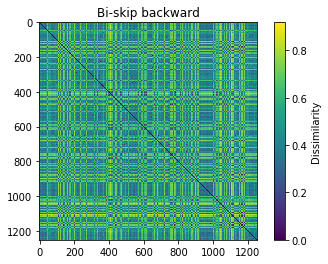

In [18]:
# import matplotlib.pylab as plt
plt.imshow(RDM_ST_Bi_b)
plt.colorbar(label = "Dissimilarity")
plt.title("Bi-skip backward")
plt.show()

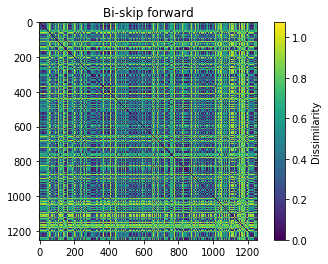

In [19]:
# import matplotlib.pylab as plt
plt.imshow(RDM_ST_Bi_f)
plt.colorbar(label = "Dissimilarity")
plt.title("Bi-skip forward")
plt.show()

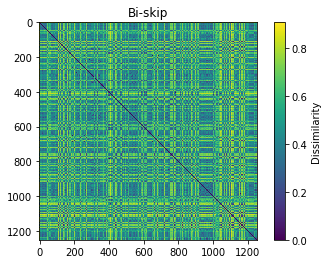

In [17]:
# import matplotlib.pylab as plt
plt.imshow(RDM_ST_Bi)
plt.colorbar(label = "Dissimilarity")
plt.title("Bi-skip")
plt.show()

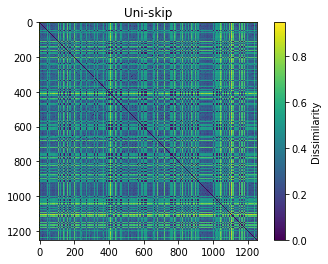

In [15]:
# import matplotlib.pylab as plt
plt.imshow(RDM_ST_Uni)
plt.colorbar(label = "Dissimilarity")
plt.title("Uni-skip")
plt.show()

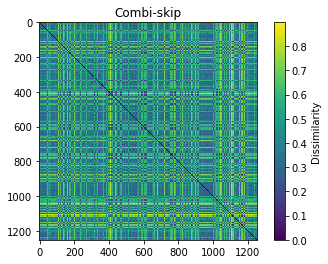

In [14]:
# import matplotlib.pylab as plt
plt.imshow(RDM_ST_Combi)
plt.colorbar(label = "Dissimilarity")
plt.title("Combi-skip")
plt.show()

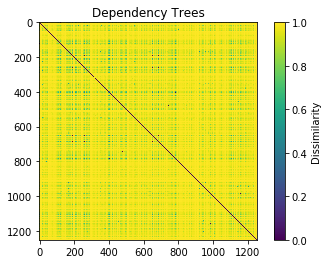

In [12]:
# import matplotlib.pylab as plt
plt.imshow(RDM_DEP_a1)
plt.colorbar(label = "Dissimilarity")
plt.title("Dependency Trees")
plt.show()

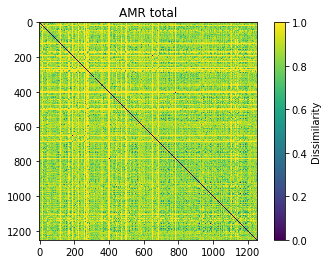

In [16]:
# import matplotlib.pylab as plt
# import numpy as np
# AMR2 = np.load("final/RDM_AMR_tot_matrix.npy")
plt.imshow(RDM_AMR_tot_m)
plt.colorbar(label = "Dissimilarity")
plt.title("AMR total")
plt.show()

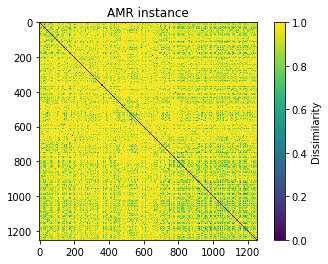

In [18]:
plt.imshow(RDM_AMR_ins_m)
plt.colorbar(label = "Dissimilarity")
plt.title("AMR instance")
plt.show()

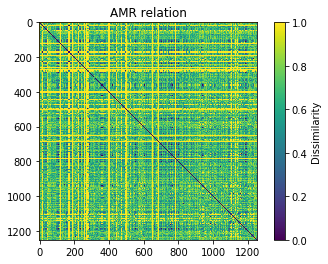

In [19]:
plt.imshow(RDM_AMR_re_m)
plt.colorbar(label = "Dissimilarity")
plt.title("AMR relation")
plt.show()

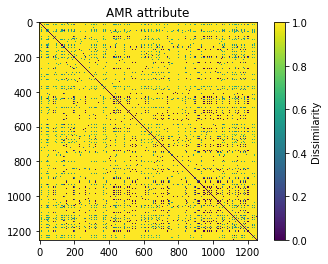

In [20]:
plt.imshow(RDM_AMR_at_m)
plt.colorbar(label = "Dissimilarity")
plt.title("AMR attribute")
plt.show()

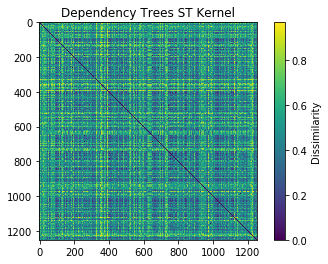

In [21]:
plt.imshow(RDM_DEP)
plt.colorbar(label = "Dissimilarity")
plt.title("Dependency Trees ST Kernel")
plt.show()

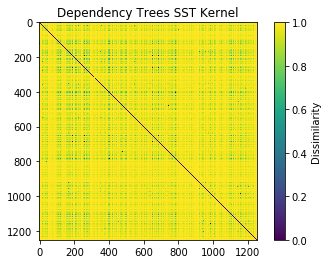

In [3]:
plt.imshow(RDM_DEP_a1)
plt.colorbar(label = "Dissimilarity")
plt.title("Dependency Trees SST Kernel")
plt.show()

### Check correlations (significance, 95% CI)

In [7]:
deps = [RDM_DEP, RDM_DEP_a1, RDM_DEP_a1_d2]
amrs = [RDM_AMR_tot, RDM_AMR_ins, RDM_AMR_re, RDM_AMR_at]
vecs = [RDM_ST_Combi, RDM_ST_Uni, RDM_ST_Bi, RDM_ST_Bi_f, RDM_ST_Bi_b]

In [47]:
r = RSA_vec(triu(deps[0]), amrs[0])
print(r[0], r[1])
print("{}, of {}".format("k", "i"))

0.1487951164096364 0.0
k, of i


In [73]:
for i in deps:
    for j in amrs:
        r = RSA_vec(triu(i), j)
#         cor = r[0]
#         sig = r[1]
#         print(round(cor, 5), sig)
#         print("{0:.5f}, {0:.5f}".format(cor, sig), end= "\t")
        print("{} {}".format(round(r[0], 5), round(r[1], 5)), end="\t")
    print()

0.1488 0.0	0.14764 0.0	0.06435 0.0	0.13407 0.0	
-0.09986 0.0	0.00316 0.00507	-0.06662 0.0	-0.03202 0.0	
0.0711 0.0	0.07295 0.0	0.02118 0.0	0.05297 0.0	


In [74]:
for i in deps:
    for j in vecs:
        r = RSA_vec(triu(i), triu(j))
        print("{} {}".format(round(r[0], 5), round(r[1], 5)), end="\t")
    print()

-0.0178 0.0	-0.04005 0.0	0.00658 0.0	0.02061 0.0	-0.02107 0.0	
0.0165 0.0	0.01673 0.0	0.01516 0.0	0.00553 0.0	0.01042 0.0	
0.0631 0.0	0.05362 0.0	0.06872 0.0	0.03667 0.0	0.06766 0.0	


In [75]:
for i in amrs:
    for j in vecs:
        r = RSA_vec(i, triu(j))
        print("{} {}".format(round(r[0], 5), round(r[1], 5)), end="\t")
    print()

0.13446 0.0	0.08699 0.0	0.17484 0.0	0.14315 0.0	0.15271 0.0	
0.09298 0.0	0.06397 0.0	0.11693 0.0	0.07178 0.0	0.1128 0.0	
0.09268 0.0	0.0551 0.0	0.12559 0.0	0.1145 0.0	0.10384 0.0	
0.07746 0.0	0.05485 0.0	0.09579 0.0	0.07562 0.0	0.08674 0.0	


### calculate CI

Got the code for pearsonr_ci from https://gist.github.com/zhiyzuo/d38159a7c48b575af3e3de7501462e04

In [6]:
import numpy as np
from scipy import stats


def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [84]:
pearsonr_ci(amrs[0], triu(deps[1]), alpha=0.05)

(-0.0998595583200744, 0.0, -0.10205002702772059, -0.09766812124943042)

In [8]:
for i in deps:
    for j in amrs:
        r,p,lo,hi = pearsonr_ci(j, triu(i)) 
#         print(round(p, 5))
        print("{}\t{}\t{}\t{}\t{}".format(round(r, 5), round(p, 5), round(lo, 5), round(hi, 5), round((hi-lo), 5)))
    print()

0.1488	0.0	0.14663	0.15096	0.00433
0.14764	0.0	0.14547	0.1498	0.00433
0.06435	0.0	0.06215	0.06655	0.00441
0.13407	0.0	0.1319	0.13625	0.00435

-0.09986	0.0	-0.10205	-0.09767	0.00438
0.00316	0.00507	0.00095	0.00538	0.00443
-0.06662	0.0	-0.06883	-0.06442	0.00441
-0.03202	0.0	-0.03423	-0.02981	0.00442

0.0711	0.0	0.06889	0.0733	0.0044
0.07295	0.0	0.07075	0.07515	0.0044
0.02118	0.0	0.01897	0.02339	0.00442
0.05297	0.0	0.05076	0.05518	0.00441



In [10]:
for i in deps:
    for j in vecs:
        r,p,lo,hi = pearsonr_ci(triu(j), triu(i)) 
#         print(round(p, 5))
        print("{}\t{}\t{}\t{}\t{}".format(round(r, 6), round(p, 6), round(lo, 6), round(hi, 6), round((hi-lo), 6)))
    print()

-0.017799	0.0	-0.020012	-0.015587	0.004425
-0.040048	0.0	-0.042257	-0.037838	0.004419
0.006578	0.0	0.004365	0.008791	0.004426
0.020613	0.0	0.018401	0.022825	0.004424
-0.021075	0.0	-0.023287	-0.018863	0.004424

0.016502	0.0	0.01429	0.018714	0.004425
0.016726	0.0	0.014513	0.018938	0.004425
0.015157	0.0	0.012944	0.017369	0.004425
0.005528	1e-06	0.003315	0.007741	0.004426
0.010418	0.0	0.008205	0.012631	0.004426

0.063102	0.0	0.060897	0.065306	0.004408
0.053624	0.0	0.051417	0.05583	0.004413
0.068723	0.0	0.06652	0.070925	0.004405
0.036668	0.0	0.034458	0.038878	0.00442
0.067659	0.0	0.065456	0.069862	0.004406



In [9]:
for i in amrs:
    for j in vecs:
        r,p,lo,hi = pearsonr_ci(triu(j), i) 
#         print(round(p, 6))
        print("{}\t{}\t{}\t{}\t{}".format(round(r, 6), round(p, 6), round(lo, 6), round(hi, 6), round((hi-lo), 6)))
    print()

0.134456	0.0	0.132282	0.136628	0.004346
0.086986	0.0	0.084789	0.089182	0.004393
0.174845	0.0	0.172699	0.176989	0.004291
0.143145	0.0	0.140977	0.145312	0.004335
0.15271	0.0	0.150548	0.154871	0.004323

0.092981	0.0	0.090786	0.095174	0.004388
0.063975	0.0	0.06177	0.066178	0.004408
0.116931	0.0	0.114748	0.119113	0.004366
0.071785	0.0	0.069583	0.073986	0.004403
0.112798	0.0	0.110613	0.114983	0.00437

0.092685	0.0	0.09049	0.094878	0.004388
0.055105	0.0	0.052898	0.057311	0.004413
0.125586	0.0	0.123407	0.127764	0.004356
0.114501	0.0	0.112317	0.116685	0.004368
0.103837	0.0	0.101647	0.106026	0.004378

0.077458	0.0	0.075258	0.079657	0.004399
0.05485	0.0	0.052644	0.057056	0.004413
0.095788	0.0	0.093595	0.09798	0.004385
0.075618	0.0	0.073417	0.077818	0.004401
0.086739	0.0	0.084543	0.088935	0.004393

